In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from datetime import datetime

df = pd.read_csv('uber_fares.csv')
df['date'] = pd.to_datetime(df['date']).dt.floor('s')

In [90]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [91]:
#df['date'] = df['date'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
# se decide no convertir a hora local porque no es necesario para la mejora del modelo

      fare_amount   date
date                    
0       11.656280   7844
1       11.663277   5908
2       11.449889   4422
3       11.725396   3256
4       14.134753   2365
5       16.003157   1967
6       11.920382   4139
7       11.122868   7231
8       10.895563   9075
9       10.948391   9339
10      11.027127   8944
11      11.192338   9422
12      11.171030   9924
13      11.477327  10024
14      11.976106   9749
15      11.935719   9614
16      11.793926   8313
17      11.486387   9758
18      10.918580  12072
19      10.562739  12605
20      10.797566  11755
21      10.955157  11446
22      11.306669  11023
23      11.577484   9805


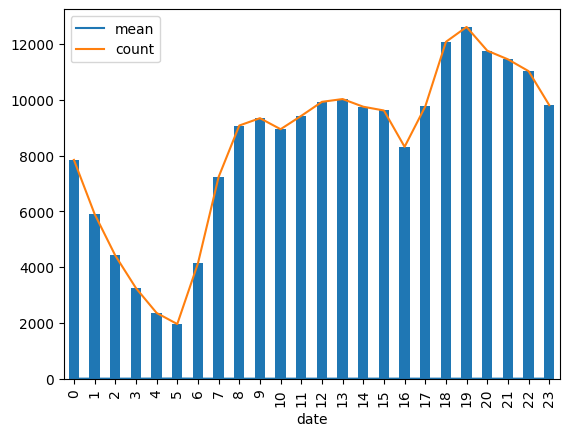

In [92]:
# 1. Frecuencia y promedio de fare_amount por hora
df.groupby(df['date'].dt.hour)['fare_amount'].agg(['mean', 'count']).plot()

# 2. Distribución de viajes por hora
df['date'].dt.hour.value_counts().sort_index().plot(kind='bar')

# 3. Definir alta demanda
hourly_stats = df.groupby(df['date'].dt.hour).agg({
    'fare_amount': 'mean',
    'date': 'count'  # conteo de viajes
})
print(hourly_stats)

In [93]:
# 1. VARIABLES TEMPORALES BÁSICAS

df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day

# 2. CODIFICACIÓN CÍCLICA (SENO/COSENO)

# Hora (0-23)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Día de la semana (0-6)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Mes (1-12)
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)  # -1 para que enero=0
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# Día del mes (1-31, aproximado)
df['day_of_month_sin'] = np.sin(2 * np.pi * (df['day_of_month'] - 1) / 31)
df['day_of_month_cos'] = np.cos(2 * np.pi * (df['day_of_month'] - 1) / 31)

# 3. VARIABLES CATEGÓRICAS DE CONTEXTO (dummies de partes relevantes de la semana)

# Fin de semana
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Sáb=5, Dom=6

# Días laborables específicos
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)

# 4. ANÁLISIS DE DEMANDA POR HORA (FRECUENCIA DE VIAJES)

# Contar viajes por hora para identificar patrones de demanda
hourly_trip_counts = df.groupby('hour').size().reset_index(name='trips_per_hour')
print("\nViajes por hora:")
print(hourly_trip_counts.sort_values('trips_per_hour', ascending=False))

# Hacer merge para agregar la información al dataframe
df = df.merge(hourly_trip_counts, on='hour', how='left')

# Crear niveles de demanda basados en terciles de cantidad de viajes
q33 = hourly_trip_counts['trips_per_hour'].quantile(0.33)
q66 = hourly_trip_counts['trips_per_hour'].quantile(0.66)

def classify_demand(trips):
    if trips <= q33:
        return 'low'
    elif trips <= q66:
        return 'medium'
    else:
        return 'high'

df['demand_level'] = df['trips_per_hour'].apply(classify_demand)

# One-hot encoding para demand_level
demand_dummies = pd.get_dummies(df['demand_level'], prefix='demand')
df = pd.concat([df, demand_dummies], axis=1)

# 5. RESUMEN Y LIMPIEZA

# Eliminar columnas intermedias que no necesitamos para el modelo
columns_to_drop = ['hour', 'day_of_week','trips_per_hour','demand_level', 'demand_low', 'month', 'day_of_month']
df = df.drop(columns=columns_to_drop)

# Mostrar todas las nuevas columnas creadas
new_columns = [col for col in df.columns if col not in ['pickup_longitude', 'pickup_latitude', 
               'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare_amount', 'date']]

print(f"\nCOLUMNAS CREADAS")
for col in sorted(new_columns):
    print(f"- {col}")

print(f"\nTotal de nuevas features temporales: {len(new_columns)}")

# 6. VERIFICACIÓN FINAL
print(f"Shape del dataframe: {df.shape}")
print("\nPrimeras filas de las nuevas variables:")
display(df[new_columns].head())


Viajes por hora:
    hour  trips_per_hour
19    19           12605
18    18           12072
20    20           11755
21    21           11446
22    22           11023
13    13           10024
12    12            9924
23    23            9805
17    17            9758
14    14            9749
15    15            9614
11    11            9422
9      9            9339
8      8            9075
10    10            8944
16    16            8313
0      0            7844
7      7            7231
1      1            5908
2      2            4422
6      6            4139
3      3            3256
4      4            2365
5      5            1967

COLUMNAS CREADAS
- day_of_month_cos
- day_of_month_sin
- day_of_week_cos
- day_of_week_sin
- demand_high
- demand_medium
- hour_cos
- hour_sin
- is_friday
- is_monday
- is_weekend
- key
- month_cos
- month_sin
- pickup_datetime

Total de nuevas features temporales: 15
Shape del dataframe: (200000, 22)

Primeras filas de las nuevas variables:


,key,pickup_datetime,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_month_sin,day_of_month_cos,is_weekend,is_monday,is_friday,demand_high,demand_medium
0,24238194,2015-05-07 19:52:06 UTC,-0.965926,0.258819,0.433884,-0.900969,8.660254e-01,-0.500000,0.937752,0.347305,0,0,0,True,False
1,27835199,2009-07-17 20:04:56 UTC,-0.866025,0.500000,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.101168,-0.994869,0,0,1,True,False
2,44984355,2009-08-24 21:45:00 UTC,-0.707107,0.707107,0.000000,1.000000,-5.000000e-01,-0.866025,-0.998717,-0.050649,0,1,0,True,False
3,25894730,2009-06-26 08:22:21 UTC,0.866025,-0.500000,-0.433884,-0.900969,5.000000e-01,-0.866025,-0.937752,0.347305,0,0,1,False,True
4,17610152,2014-08-28 17:47:00 UTC,-0.965926,-0.258819,0.433884,-0.900969,-5.000000e-01,-0.866025,-0.724793,0.688967,0,0,0,False,True


In [94]:
df

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_sin,...,day_of_week_cos,month_sin,month_cos,day_of_month_sin,day_of_month_cos,is_weekend,is_monday,is_friday,demand_high,demand_medium
0,24238194,2015-05-07 19:52:06,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,-0.965926,...,-0.900969,8.660254e-01,-5.000000e-01,0.937752,0.347305,0,0,0,True,False
1,27835199,2009-07-17 20:04:56,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,-0.866025,...,-0.900969,1.224647e-16,-1.000000e+00,-0.101168,-0.994869,0,0,1,True,False
2,44984355,2009-08-24 21:45:00,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,-0.707107,...,1.000000,-5.000000e-01,-8.660254e-01,-0.998717,-0.050649,0,1,0,True,False
3,25894730,2009-06-26 08:22:21,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0.866025,...,-0.900969,5.000000e-01,-8.660254e-01,-0.937752,0.347305,0,0,1,False,True
4,17610152,2014-08-28 17:47:00,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,-0.965926,...,-0.900969,-5.000000e-01,-8.660254e-01,-0.724793,0.688967,0,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,0.500000,...,0.623490,-1.000000e+00,-1.836970e-16,-0.724793,0.688967,1,0,0,False,True
199996,16382965,2014-03-14 01:09:00,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,0.258819,...,-0.900969,8.660254e-01,5.000000e-01,0.485302,-0.874347,0,0,1,False,False
199997,27804658,2009-06-29 00:42:00,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,0.000000,...,1.000000,5.000000e-01,-8.660254e-01,-0.571268,0.820763,0,1,0,False,False
199998,20259894,2015-05-20 14:56:25,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,-0.500000,...,-0.222521,8.660254e-01,-5.000000e-01,-0.651372,-0.758758,0,0,0,False,True
